# Single Minima Potential Field Gradient Based Path Planner for Dynamical Environments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Conventions
* The occupancy map has 1s at the boundaries. We assume that the robot is not allowed to leave the map, since there it would not be able to navigate anyways. (SLAM is not working there)
* The robot position is denoted by -2
* The goal is denoted by -1
* Obstacles are denoted by 1
* Originally free space is denoted by 0

## 1: The Pixel class and the Repulsive gradient field:

In [2]:
class Pixel:
    """Class representing a grid pixel."""
    def __init__(self, 
                 x,
                 y,
                 value=0,
                 grad=np.array([0, 0])):
        """Initializes a pixel."""
        self.x = x
        self.y = y
        self.value = 0
        self.grad = grad
    
    
    def normalize_grad(self):
        """Normalizes its gradient."""
        self.scale_grad()
        
        
    def scale_grad(self, L=1.0, eps=1e-6):
        """Scales its gradient to be the lenght specified by L"""
        length = np.linalg.norm(self.grad)
        if length > eps:
            self.grad = self.grad / length * L
        else:
            self_grad = np.array([0, 0])

In [54]:
def get_repulsive_field(occupancy_grid, R):
    """
    Function to obtain the repulsive potential field based on an occupancy grid.
    Input:
        - occupancy_grid: np.array(N, M), the occupancy grid
        - R: scalar, max distrance to propagate from any obstacle
    Output:
        - rep_field: np.array(N, M) of pixels: The repulsive field that was produced
    """
    N, M = occupancy_grid.shape
    occ_shape = np.array([N, M])
    # queue for carrying out the expansion around the obstacles:
    queue = []
    # np.array of pixels:
    rep_field = np.ndarray(occupancy_grid.shape, dtype=np.object)
    for i in range(occupancy_grid.shape[0]):
        for j in range(occupancy_grid.shape[1]):
            rep_field[i, j] = Pixel(i, j)
            if occupancy_grid[i, j] == 1:
                rep_field[i, j].value = 1
                # adding the indices of obstacles to the queue:
                queue.append(np.array([i, j]))
    
    
    # carrying out the expansion while the queue is not empty:
    search_directions = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
    while queue:
        ind = queue.pop(0)
        pix = rep_field[ind[0], ind[1]]
        # iterate over the neighboring pixels:
        for direction in search_directions:
            new_ind = ind + direction
            if (new_ind >= 0).all() and (new_ind < occ_shape).all():
                new_pix = rep_field[new_ind[0], new_ind[1]]
                # if the goal is free space or goal, calculate the value and the gradient of the new pixel:
                if (new_pix.value == 0):
                    set_new_pixel_rep(pix, new_pix, rep_field, occ_shape)
                    scale_gradient_rep(new_pix, R)
                    # at a distance of R from a boundary the gradient should be already zero, so it is 
                    # not necessary to further expand a node, which's child will already be over R.
                    # new_pix - 1 is needed since the value of an obstacle is already 1
                    if (new_pix.value - 1) < R - 1:
                        queue.append(new_ind)
    
    return rep_field

In [168]:
def set_new_pixel_rep(pix, new_pix, rep_field, occ_shape):
    """Sets up the value and the gradient of a new pixel for the repulsive field."""
    
    # setting the value of the pixel:
    new_pix.value = pix.value + 1
    new_pix.grad = np.array([0, 0])
    
    # the gradient of the pixel is the sum of directions which point from neigboring pixels
    # with smaller values to this point. The summed vector is normalized at the end.
    ind = np.array([new_pix.x, new_pix.y])
    search_directions = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
    
    for direction in search_directions:
        old_ind = ind + direction
        if (old_ind >= 0).all() and (old_ind < occ_shape).all():
            old_pix = rep_field[old_ind[0], old_ind[1]]
            if (old_pix.value != 0) and (old_pix.value < new_pix.value):
                new_pix.grad -= direction
    
    new_pix.normalize_grad()
    
    
def scale_gradient_rep(new_pix, R):
    """
    Scales the gradient of the pixel. The repulsive gradients have lenght 1 at
    an obstacle boarder and and 0 if they are further away from the boarder then R. 
    Between them the length varies linearly.
    """
    new_pix.grad = new_pix.grad * (1 - (new_pix.value - 2) / R)

In [169]:
def plot_grad_field(field, occupancy_grid):
    """Plots the gradient field of the np.array of pixels given by field"""
    eps = 1e-6
    N, M = field.shape
    
    # matrix for the x and y coordinates in every point:
    x, y = np.zeros((N, M)), np.zeros((N, M))  
    for i in range(N):
        for j in range(M):
            x[i, j] = field[i, j].grad[0] + eps
            y[i, j] = field[i, j].grad[1] + eps
    
    # plotting:
    plt.figure(figsize=(16, M / N * 16))
    f, ax = plt.subplots(1, 1, figsize=(16, M / N * 16))
    ax.quiver(x.T, -y.T, scale=1, scale_units='xy')
    ax.matshow(occupancy_grid.T)
    plt.show()

In [208]:
# Testing the repulsive potential field generation:
scale = 2
M = 32 * scale
N = 32 * scale
R = 5  * scale
goal_position = (25 * scale, 6 * scale) 
start_position = (7 * scale, 25 * scale)

# creating the boarder:
occupancy_grid = np.ones((M, N))
occupancy_grid[1: -1, 1: -1] = np.zeros((M - 2, N - 2))
# setting start and goal:
occupancy_grid[goal_position] = -1
occupancy_grid[start_position] = -2

# obstacles:
occupancy_grid[4 * scale: 9 * scale, 10 * scale: 16 * scale] = 1
occupancy_grid[15 * scale: 20 * scale, 9 * scale: 13 * scale] = 1
# u-shaped obstacle:
occupancy_grid[16 * scale: 26 * scale, 20 * scale: 22 * scale] = 1
occupancy_grid[16 * scale: 18 * scale, 21 * scale: 26 * scale] = 1
occupancy_grid[24 * scale: 26 * scale, 21 * scale: 26 * scale] = 1
occupancy_grid[18 * scale: 20 * scale, 25 * scale: 26 * scale] = 1
occupancy_grid[22 * scale: 24 * scale, 25 * scale: 26 * scale] = 1

rep_field = get_repulsive_field(occupancy_grid, R)

<Figure size 1152x1152 with 0 Axes>

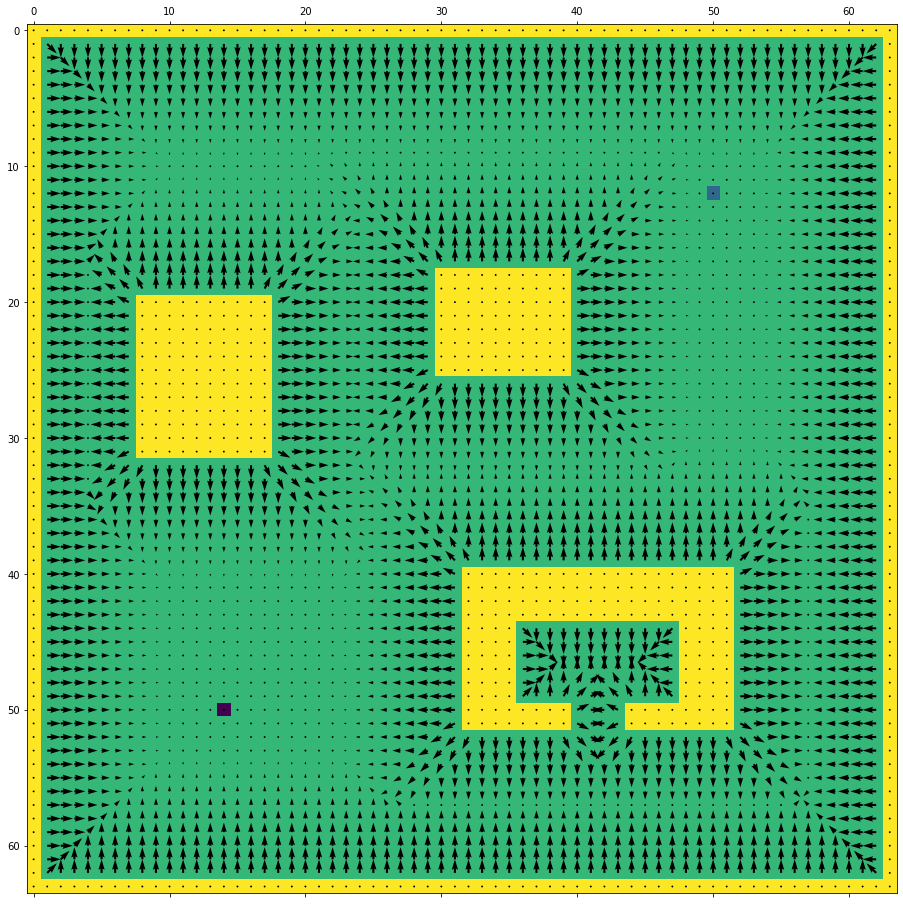

In [209]:
# plotting the repulsive gradient field:
plot_grad_field(rep_field, occupancy_grid)

## 2: Attractor field:

In [210]:
def get_attractor_field(occupancy_grid):
    """
    Wavefront planner started from the goal.
    Input:
        - occupancy_grid: np.array(N, M)
    Output:
        - attractor_field: np.array(N, M), The repulsive field that was produced
    """
    
    N, M = occupancy_grid.shape
    occ_shape = np.array([N, M])
    # queue for carrying out the expansion around the obstacles:
    queue = []
    # np.array of pixels:
    attractor_field = np.ndarray(occupancy_grid.shape, dtype=np.object)
    for i in range(occupancy_grid.shape[0]):
        for j in range(occupancy_grid.shape[1]):
            attractor_field[i, j] = Pixel(i, j)
            if occupancy_grid[i, j] == 1:
                attractor_field[i, j].value = 1
            elif occupancy_grid[i, j] == -1:
                attractor_field[i, j].value = -1
                queue.append(np.array([i, j]))
                
    # carrying out the expansion while the queue is not empty:
    #search_directions = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
    search_directions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    while queue:
        ind = queue.pop(0)
        pix = attractor_field[ind[0], ind[1]]
        # iterate over the neighboring pixels:
        for direction in search_directions:
            new_ind = ind + direction
            if (new_ind >= 0).all() and (new_ind < occ_shape).all():
                new_pix = attractor_field[new_ind[0], new_ind[1]]
                # if the goal is free space or goal, calculate the value and the gradient of the new pixel:
                if (new_pix.value == 0):
                    set_new_pixel_attr(pix, new_pix, attractor_field, occ_shape)
                    queue.append(new_ind)
        
    
    return attractor_field

In [225]:
def set_new_pixel_attr(pix, new_pix, attractor_field, occ_shape):
    """Sets up a new pixels value and gradient for the attractor field."""
    
    # setting the value of the pixel:
    new_pix.value = pix.value - 1
    new_pix.grad = np.array([0, 0])
    
    # summing up the gradients which point to points which are closer to the goal:
    ind = np.array([new_pix.x, new_pix.y])
    search_directions = [[1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1]]
    
    for direction in search_directions:
        old_ind = ind + direction
        if (old_ind >= 0).all() and (old_ind < occ_shape).all():
            old_pix = attractor_field[old_ind[0], old_ind[1]]
            if (old_pix.value < 0) and (old_pix.value > new_pix.value):
                new_pix.grad += np.array(direction)
                
    new_pix.normalize_grad()
                
    # if the sum is accidentaly zero, or if it points to an obstacle: 
    # set grad to point to the first direction that it finds feasible:
    # The search_directions list is structured so, that pixels which are touching this
    # pixel with a side are taken first.
    grad_is_zero = (new_pix.grad[0] == 0) and (new_pix.grad[1] == 0)
    # check if neighbour is opccupied:
    neighbour_indices = np.floor(ind + np.array([0.5, 0.5]) + new_pix.grad)
    neighbour_is_occupied = (attractor_field[int(neighbour_indices[0]), int(neighbour_indices[1])].value == 1)
    
    if grad_is_zero or neighbour_is_occupied:
        for direction in search_directions:
            old_ind = ind + direction
            if (old_ind >= 0).all() and (old_ind < occ_shape).all():
                old_pix = attractor_field[old_ind[0], old_ind[1]]
                if (old_pix.value < 0) and (old_pix.value > new_pix.value):
                    new_pix.grad = np.array(direction)
                    break
        new_pix.normalize_grad()

<Figure size 1152x1152 with 0 Axes>

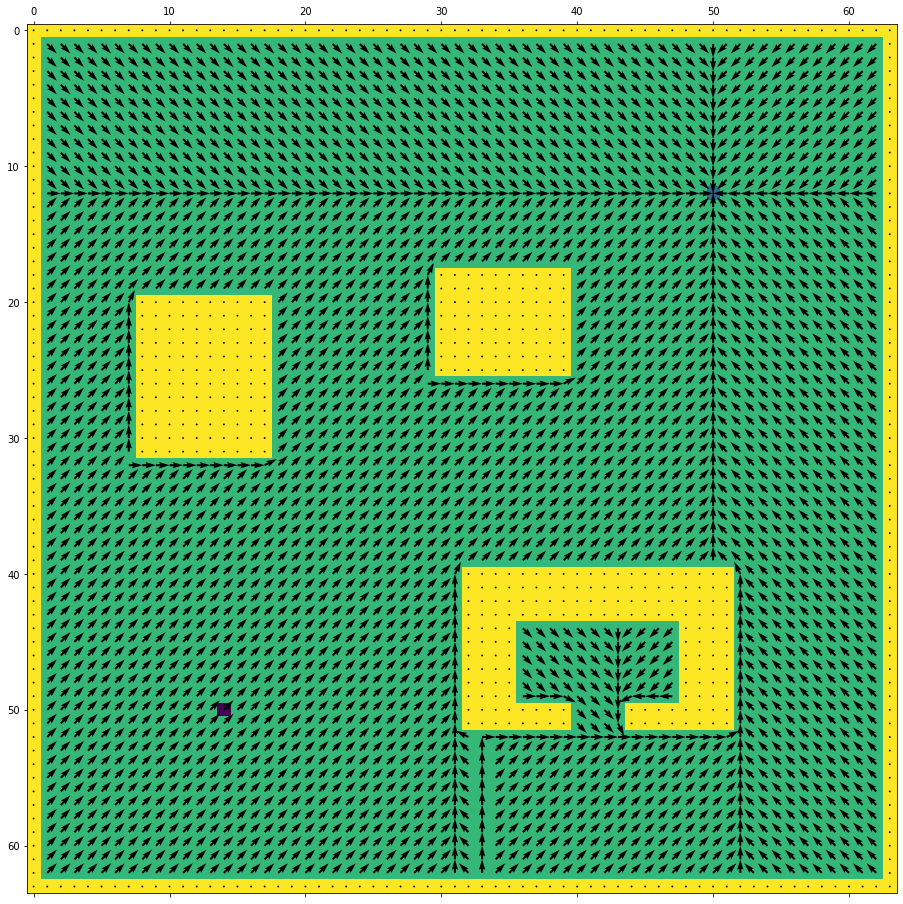

In [226]:
# calculating and plotting the attractor gradient field:
attractor_field = get_attractor_field(occupancy_grid)
plot_grad_field(attractor_field, occupancy_grid)

## Combining the two gradient fields:

In [227]:
def combine_grad_fields(field1, field2):
    """
    Combines two gradient fields by summing the gradiends in every point. 
    The absolute values of each pixel are not interesting.
    Inputs:
        - field1: np.array(N, M) of Pixels.
        - field2: np.array(N, M) of Pixels.
    Output:
        - out_field: np.array(N, M) of Pixels.
    """
    
    assert field1.shape[0] == field2.shape[0], "field1.shape[0] != field2.shape[0]"
    assert field1.shape[1] == field2.shape[1], "field1.shape[1] != field2.shape[1]"
    
    out_field = np.ndarray(field1.shape, dtype=np.object)
    N, M = field1.shape
    
    for i in range(N):
        for j in range(M):
            grad = field1[i, j].grad + field2[i, j].grad
            out_field[i, j] = Pixel(i, j, 0, grad)
            out_field[i, j].normalize_grad()
    
    return out_field

<Figure size 1152x1152 with 0 Axes>

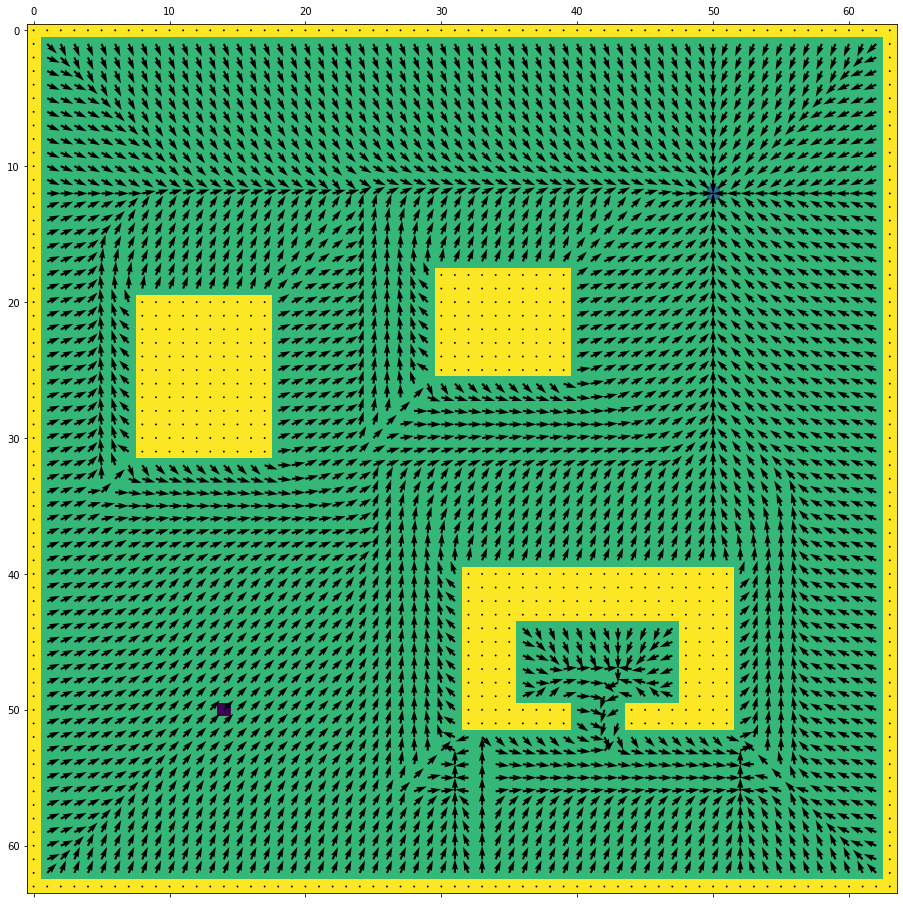

In [228]:
# combining and plotting the total gradient field:
total_grad_field = combine_grad_fields(rep_field, attractor_field)
plot_grad_field(total_grad_field, occupancy_grid)